In [1]:
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')

from tqdm import tqdm

import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

nltk.download('wordnet')
nltk.download('stopwords')

from utils.caching import cache, ucache

import os
if not os.path.exists('out'):
    os.makedirs('out')

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\calva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\calva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data reading and cleanup

The [Book Summary Dataset](https://www.cs.cmu.edu/~dbamman/booksummaries.html) is used.

The entries in the dataset (taken from its README file) are:
 1. Wikipedia article ID
 2. Freebase ID
 3. Book title
 4. Author
 5. Publication date
 6. Book genres (Freebase ID:name tuples)
 7. Plot summary

To save time, I rename them as follows:

| Original name     | renaming     |
| :---: | :---: |
| Wikipedia article ID | id |
| Freebase ID | f_id |
| Book title | title |
| Author | author |
| Publication date | date |
| Book genres (Freebase ID:name tuples) | genres |
| Plot summary | summary |




In [2]:
headers = ["id", "f_id", "title", "author", "date", "genres", "summary"]

df_original = pd.read_csv('dataset/booksummaries.txt', sep='\t', names=headers)
print(f'Number of documents: {len(df_original)}')
df_original.head()

Number of documents: 16559


,id,f_id,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


## Data preprocessing

First make a dataframe for a nice visualization:
 - drop the Freebase ID column
 - convert the genres to lists of lowercase strings

Then add the tokenized columns for `summary` and `title`:
 - convert everything to lowercase
 - keep only alphabetic characters (drop digits and punctuation)
 - strip accents
 - On the `summary` column:
   - remove stopwords
   - remove words that make no sense
   - lemmatize words

Build bag-of-words of each document, where the format is:

 - {word: n_occurrences}


Finally, build the vocabulary of the summary. Only the words that appear in more than 1% of the documents are kept in the vocabulary, i.e the ones that appear in more than 17 documents.

In [3]:
# drop freebase ID
df = df_original.drop('f_id', axis=1)

# convert genres to lists of strings
df['genres'] = df['genres'].map(lambda x: list(json.loads(x.lower()).values()), na_action='ignore')

df.head()

,id,title,author,date,genres,summary
0,620,Animal Farm,George Orwell,1945-08-17,"[roman à clef, satire, children's literature, ...","Old Major, the old boar on the Manor Farm, ca..."
1,843,A Clockwork Orange,Anthony Burgess,1962,"[science fiction, novella, speculative fiction...","Alex, a teenager living in near-future Englan..."
2,986,The Plague,Albert Camus,1947,"[existentialism, fiction, absurdist fiction, n...",The text of The Plague is divided into five p...
3,1756,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,A Fire Upon the Deep,Vernor Vinge,NaN,"[hard science fiction, science fiction, specul...",The novel posits that space around the Milky ...


In [4]:
# intitiate the tokenizer and lemmatizer
tokenizer = RegexpTokenizer(r'[a-z]+')
lemmatizer = WordNetLemmatizer()

# convert stopwords to set for better performance
stopwords_set = set(stopwords.words('english'))

# define all mapping functions for proper tokenization
def strip_accents(text: str):
   return ''.join(c for c in unicodedata.normalize('NFD', text)
                  if unicodedata.category(c) != 'Mn')

def tokenize(text: str):
    return tokenizer.tokenize(text)

def remove_single_chars(words: list):
    return [word for word in words if len(word) > 1]

def lemmatize(words: list):
    return [lemmatizer.lemmatize(word) for word in words]

def remove_stopwords(words: list):
    return [word for word in words if word not in stopwords_set]

def apply_preprocessing(text: str):
    return lemmatize(remove_stopwords(remove_single_chars(tokenize(strip_accents(text.lower())))))

tqdm.pandas() # defines the progress_map function

for key in ['title', 'summary']:
    df[key + '_t'] = cache(f'prep_{key}.pck', df[key].progress_map, apply_preprocessing)

df.head()

Loading cached result from: .my_cache\prep_title.pck
Done
Loading cached result from: .my_cache\prep_summary.pck
Done


,id,title,author,date,genres,summary,title_t,summary_t
0,620,Animal Farm,George Orwell,1945-08-17,"[roman à clef, satire, children's literature, ...","Old Major, the old boar on the Manor Farm, ca...","[animal, farm]","[old, major, old, boar, manor, farm, call, ani..."
1,843,A Clockwork Orange,Anthony Burgess,1962,"[science fiction, novella, speculative fiction...","Alex, a teenager living in near-future Englan...","[clockwork, orange]","[alex, teenager, living, near, future, england..."
2,986,The Plague,Albert Camus,1947,"[existentialism, fiction, absurdist fiction, n...",The text of The Plague is divided into five p...,[plague],"[text, plague, divided, five, part, town, oran..."
3,1756,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...,"[enquiry, concerning, human, understanding]","[argument, enquiry, proceeds, series, incremen..."
4,2080,A Fire Upon the Deep,Vernor Vinge,NaN,"[hard science fiction, science fiction, specul...",The novel posits that space around the Milky ...,"[fire, upon, deep]","[novel, posit, space, around, milky, way, divi..."


Build bag-of-words for each document. This is useful for computing the document frequency

In [5]:
# define function to build bag-of-words
def build_bow(doc: list):
    """Count the words in each and build its bag-of-words"""
    bow = {}
    for word in doc:
        if word not in bow.keys():
            bow[word] = 0
        bow[word]+=1
    return dict(sorted(bow.items(), key=lambda item: item[1], reverse=True))


# do it only on the summary
t0 = time.time()
# df['summary_set'] = df['summary_t'].map(lambda s: sorted(set(s))) # build the set just for better performance
df['summary_bow'] = df['summary_t'].map(build_bow) # this enables to build the tf part of the tf-idf matrix
t1 = time.time()
print(f'execution time: {t1-t0:.2f}s')

df.head()

execution time: 1.49s


,id,title,author,date,genres,summary,title_t,summary_t,summary_bow
0,620,Animal Farm,George Orwell,1945-08-17,"[roman à clef, satire, children's literature, ...","Old Major, the old boar on the Manor Farm, ca...","[animal, farm]","[old, major, old, boar, manor, farm, call, ani...","{'animal': 37, 'napoleon': 19, 'pig': 14, 'far..."
1,843,A Clockwork Orange,Anthony Burgess,1962,"[science fiction, novella, speculative fiction...","Alex, a teenager living in near-future Englan...","[clockwork, orange]","[alex, teenager, living, near, future, england...","{'alex': 40, 'gang': 8, 'violence': 6, 'droogs..."
2,986,The Plague,Albert Camus,1947,"[existentialism, fiction, absurdist fiction, n...",The text of The Plague is divided into five p...,[plague],"[text, plague, divided, five, part, town, oran...","{'plague': 20, 'town': 13, 'rieux': 12, 'tarro..."
3,1756,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...,"[enquiry, concerning, human, understanding]","[argument, enquiry, proceeds, series, incremen...","{'hume': 59, 'one': 23, 'experience': 18, 'hum..."
4,2080,A Fire Upon the Deep,Vernor Vinge,NaN,"[hard science fiction, science fiction, specul...",The novel posits that space around the Milky ...,"[fire, upon, deep]","[novel, posit, space, around, milky, way, divi...","{'blight': 12, 'ship': 11, 'human': 9, 'one': ..."


### Dataset statistics

In [320]:
print(f'There are {len(df)} documents')

There are 16559 documents


Distribution of the document lengths (number of tokens after preprocessing and lemmatization)

document lengths:
min: 0.00
mean: 233.02
max: 5095.00
std: 266.15
median: 144.00


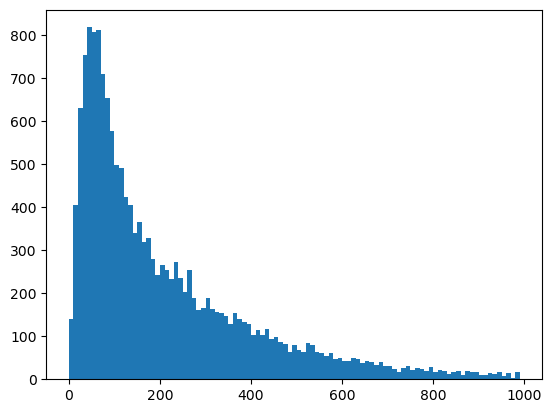

In [337]:
doc_lengths = np.array(df['summary_t'].map(lambda l: len(l)))

print('document lengths:')
print(f'min: {np.min(doc_lengths):.2f}')
print(f'mean: {np.mean(doc_lengths):.2f}')
print(f'max: {np.max(doc_lengths):.2f}')
print(f'std: {np.std(doc_lengths):.2f}')
print(f'median: {np.median(doc_lengths):.2f}')


plt.hist(doc_lengths, bins=np.arange(0, 1000, 10))
plt.show()

## Build vocabulary

The vocabulary is build from all the tokens present in the bag-of-words of each doc.

In [6]:
# take the complete vocabulary and compute the document frequency
vocabulary_complete = [word for doc in df['summary_bow'] for word in doc.keys()]

from utils.document_frequency import compute_document_frequency
document_frequency = cache('doc_freq.pck', compute_document_frequency, df, vocabulary_complete)

Loading cached result from: .my_cache\doc_freq.pck
Done


In [7]:
# build the actual vocabulary
min_df = 0.01
print(f'Min number of document frequency: {len(df)*min_df}')
vocabulary = [token for token, freq in document_frequency.items() if freq > len(df)*min_df]

# create mappings for vocabulary
token2id = {word: i for i, word in enumerate(vocabulary)}
id2token = {i: word for word, i in token2id.items()}

print(f'Vocabulary size: {len(vocabulary)}')

Min number of document frequency: 165.59
Vocabulary size: 2840


### Vocabulary statistics

In [343]:
np.max(list(document_frequency.values()))

8251

document frequencies:
min: 1
mean: 23.85
max: 8251
std: 160.69
median: 1.0


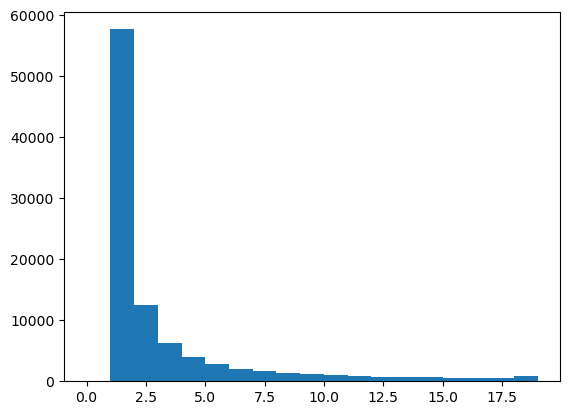

In [358]:
term_freqs = np.array(list(document_frequency.values()))

print('document frequencies:')
print(f'min: {np.min(term_freqs)}')
print(f'mean: {np.mean(term_freqs):.2f}')
print(f'max: {np.max(term_freqs)}')
print(f'std: {np.std(term_freqs):.2f}')
print(f'median: {np.median(term_freqs)}')


plt.hist(term_freqs, bins=np.arange(0, 20, 1))
plt.show()

# Tf-idf

The terms-docs matrix with tf-idf weighting is computed.
The tf-idf weighting $w_{t,d}$ is computed as follows:

$$
w_{t,d} = \log{(i+tf_{t,d})} \cdot \log{N/df_t},
$$

Where the parameters are:
 - $tf_{t,d}$: term frequency (n of occurrences) of term $t$ in document $d$
 - $N$: number of documents
 - $df_t$: number of documents in which term $t$ occurs.

In [359]:
def compute_tf_idf(df, id2token):
    tf_idf = np.zeros((len(vocabulary), len(df)))
    for i, word in tqdm(id2token.items()):
        for j, bow in enumerate(df['summary_bow']):
            if word in bow:
                tf_idf[i,j] = np.log(1+bow[word])*np.log(document_frequency[word])
    return tf_idf


tf_idf = cache('if-idf.pck', compute_tf_idf, df, id2token)
print(f'{tf_idf.shape[0]} words and {tf_idf.shape[1]} documents.')

Loading cached result from: .my_cache\if-idf.pck
Done
2840 words and 16559 documents.


# LSA on tf-idf matrix

LSA is performed in the latent semantic space.

At first, SVD is performed on the terms-docs matrix.
The SVD of an $m \times n$ matrix $A$ decomposes it in 3 other matrices:
$$
A = U \Sigma V^T
$$

where:
 - $U$ is an orthogonal matrix. It contains the left singular vectors of $A$, which represent the relationships between the rows of $A$. Its shape is $m \times m$.
 - $\Sigma$ is a diagonal matrix. It contains the singular values of $A$, which represent the scaling factors along the orthogonal directions defined by $U$ and $V^T$. By convention, they are ordered in descending order. Its shape is $m \times n$.
 - $V^T$ is the transpose of an orthogonal matrix. It contains the right singular vectors of $A$, which represent the relationships between the columns of $A$. Its shape is $n \times n$.
 - To save storage space, the shapes of the $U$, $\Sigma$ and $V^T$ can be reduced to $m \times d$, $d \times d$ and $d \times n$ respectively, where $d=\min(m,n)$

If $A$ is a (optionally tf-idf weighted) terms-docs matrix, the columns of $U$ represent the singular vectors associated to each term, and the rows of $V^T$ the singular vectors associated to the documents.

The LSA space is obtained by performing a k-rank approximation of $A$. This is done by truncating the singular values up do the $k$ th one.


In [360]:
u, s, vt = cache('svd_tf_idf.pck', np.linalg.svd, tf_idf, full_matrices=False)

Loading cached result from: .my_cache\svd_tf_idf.pck
Done


## LSA space visualization

### LSA space of documents

Visualize the first 2 LSA dimensions for the docs, i.e. the $V^T$ matrix.

In [362]:
from utils.visualization import plot_docs, animate_k

At first, it is a good idea to tune the value of k. This is achieved by creating and animation using the FuncAnimation class from matplotlib

In [363]:
k_values = [2, 3, 4, 5, 10] + list(range(20, 110, 10)) + list(range(100, 1100, 100)) + [2000, 5000, 10000, vt.shape[1]]
animate_k('out/docs_animation.mp4', k_values, plot_docs,
          vt=vt, s=s, dimensions=(0,1), normalize=True, scatter_kw={'s': 1, 'alpha': 0.3})

Check file: .my_cache\e3f359d9aaaa926fa1ab4b7aef829a8d9e75f82c already exists


In [364]:
k_values = [3, 4, 5, 10] + list(range(20, 110, 10)) + list(range(100, 1100, 100)) + [2000, 5000, 10000, vt.shape[1]]
animate_k('out/docs_animation_2.mp4', k_values, plot_docs,
          vt=vt, s=s, dimensions=(1,2), normalize=True, scatter_kw={'s': 1, 'alpha': 0.3})

Check file: .my_cache\4648413007f5459ff35189ca52e65a6f60c62fab already exists


Looking at the animations, the best spread of the data points occurs at around $k=100$.

Therefore, from now on, for the docs this value for k will be chosen for LSA space visualization.

Here is a visualization of the unnormalized LSA vectors (left), and the normalized k-rank approximated ones for LSA dimensions (0,1) (right).

Showing only 1000 datapoints out of 16559
Showing only 1000 datapoints out of 16559


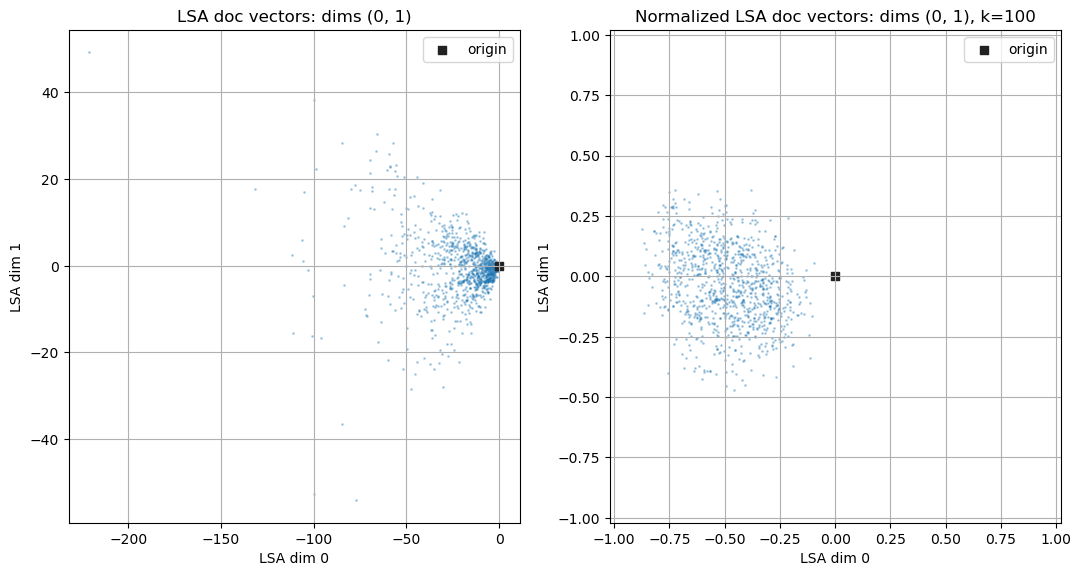

In [15]:
w, h, dpi = 640*2, 640, 100
fig, axs = plt.subplots(ncols=2, figsize=(w/dpi, h/dpi), dpi=dpi)

# a random subsample is shown, because with all the points my PC does not handle the rendering very well
plot_docs(vt, s, (0,1), k=100, normalize=False, ax=axs[0], scatter_kw={'s': 1, 'alpha': 0.3}, subsample_size=1000)
plot_docs(vt, s, (0,1), k=100, normalize=True,  ax=axs[1], scatter_kw={'s': 1, 'alpha': 0.3}, subsample_size=1000)

plt.show()

And for LSA dimensions (1,2)

Showing only 1000 datapoints out of 16559
Showing only 1000 datapoints out of 16559


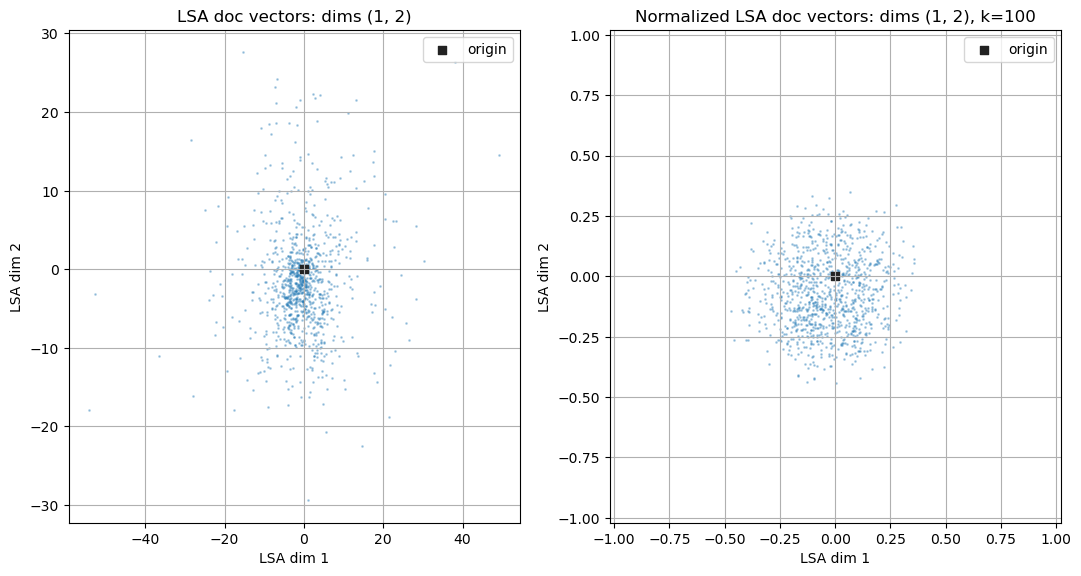

In [16]:
w, h, dpi = 640*2, 640, 100
fig, axs = plt.subplots(ncols=2, figsize=(w/dpi, h/dpi), dpi=dpi)

plot_docs(vt, s, (1,2), k=100, normalize=False, ax=axs[0], scatter_kw={'s': 1, 'alpha': 0.3}, subsample_size=1000)
plot_docs(vt, s, (1,2), k=100, normalize=True,  ax=axs[1], scatter_kw={'s': 1, 'alpha': 0.3}, subsample_size=1000)

plt.show()

#### Display some specific docs

Show only some specific book summaries. The commented cells were used to check if the Title I want to show was present

In [17]:
# t = "A Farewell to Arms"
# df.loc[df['title'].map(lambda s: s.lower()).str.contains(t.lower())]

In [18]:
# df.loc[df['title'].str.lower() == t.lower()]

In [19]:
# df.loc[df['author'].str.lower() == 'Ernest Hemingway'.lower()]

In [21]:
titles = ["Hercule Poirot's Christmas", "Murder on the Orient express",
          "Nightfall", "Robots and Empire", "Foundation", "Second Foundation",
          "Harry potter and the Philosopher's stone",
          "The fellowship of the Ring", "The Two Towers", "The Return of the King", "The Hobbit",
          "The da Vinci Code", "Angels and Demons",
          "Pride and Prejudice",
          "The Shining",
          "Moby-Dick; or, The Whale", "A Farewell to Arms"]

doc_subset = list(df[(df['title'].map(lambda t: t in titles) & ~df['author'].isna() & ~df['genres'].isna())].index)
df.loc[doc_subset][['author', 'title', 'genres']]

,author,title,genres
53,Herman Melville,"Moby-Dick; or, The Whale","[sea story, fiction, adventure novel]"
65,Jane Austen,Pride and Prejudice,"[satire, fiction, romance novel, novel]"
82,Stephen King,The Shining,"[gothic fiction, children's literature, horror..."
85,J. R. R. Tolkien,The Hobbit,"[children's literature, juvenile fantasy, adve..."
229,Ernest Hemingway,A Farewell to Arms,"[fiction, novel]"
248,J. R. R. Tolkien,The Two Towers,"[science fiction, children's literature, fanta..."
249,J. R. R. Tolkien,The Return of the King,"[science fiction, biography, speculative ficti..."
811,Isaac Asimov,Robots and Empire,"[science fiction, speculative fiction, fiction]"
812,Isaac Asimov,Foundation,"[science fiction, speculative fiction, childre..."
813,Isaac Asimov,Second Foundation,"[science fiction, speculative fiction, childre..."


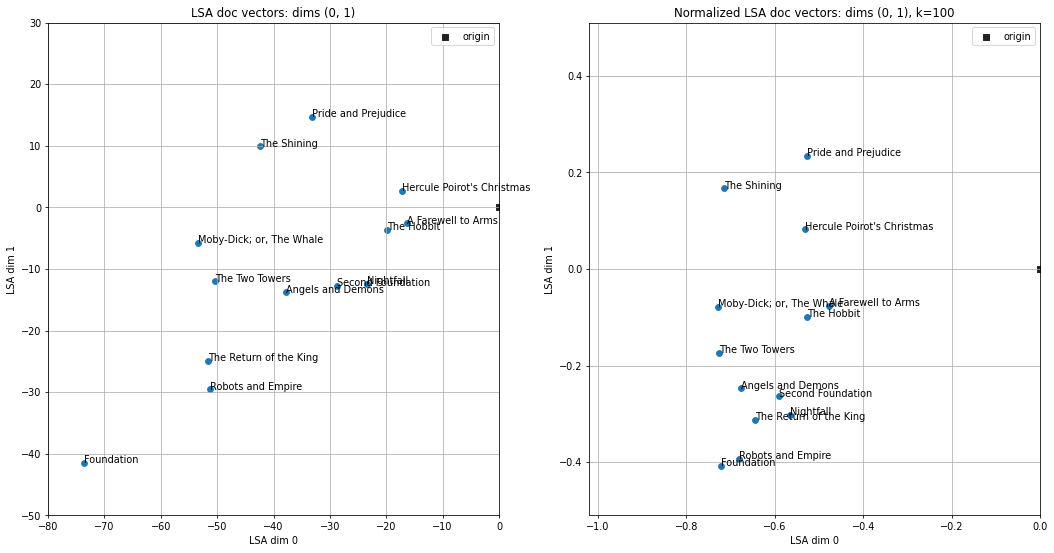

In [22]:
w, h, dpi = 640*2, 640, 70
fig, axs = plt.subplots(ncols=2, figsize=(w/dpi, h/dpi), dpi=dpi)

plot_docs(vt, s, (0,1), k=100, normalize=False, ax=axs[0], subset=doc_subset, labels=df['title'].to_numpy())
plot_docs(vt, s, (0,1), k=100, normalize=True,  ax=axs[1], subset=doc_subset, labels=df['title'].to_numpy())

axs[0].set_xlim(-80,0)
axs[0].set_ylim(-50, 30)

axs[1].set_xlim(-1.02,0)
axs[1].set_ylim(-0.51,0.51)

plt.show()

### LSA space of words

Visualize the first 2 LSA dimensions for the words, i.e. the $U$ matrix.

In [23]:
from utils.visualization import plot_words

Tuning of the approximation level k.

In [24]:
k_values = [2, 3, 4, 5, 10] + list(range(20, 110, 10)) + list(range(100, 1100, 100)) + [1500, 2000, u.shape[1]]
animate_k('out/words_animation.mp4', k_values, plot_words,
          u=u, s=s, dimensions=(0,1), normalize=True, scatter_kw={'s': 1, 'alpha': 0.3})

animate_k('out/words_animation_2.mp4', k_values[1:], plot_words,
          u=u, s=s, dimensions=(1,2), normalize=True, scatter_kw={'s': 1, 'alpha': 0.3})

Check file: .my_cache\63e331e1f9265b89b69e3c5c715a6ba7532cb6c4 created
Creating animation
Done      
Check file: .my_cache\ff4aedf863bc68ae09ec241de7cd5966285b7445 already exists


<Figure size 640x640 with 0 Axes>

Here, some specific words are chosen. I have chosen 4 different categories of words. As it turns out, using small values of k results in the best visualization for the clustering of these specific words.

### Display some specific words

In [26]:
words_of_interest = ['love', 'marriage', 'parent', 'school',
                     'dark', 'fight', 'criminal',
                     'alien', 'spaceship', 'planet',
                     'car', 'truck', 'bus', 'train']

words_subset = []
voc = np.array(vocabulary)
for word_of_interest in words_of_interest:
    words_subset += list(np.indices(dimensions=voc.shape)[0][voc==word_of_interest])

In [27]:
k_values = [2, 3, 4, 5, 10] + list(range(20, 110, 10)) + list(range(100, 1100, 100)) + [1500, 2000, u.shape[1]]
animate_k('out/words_animation_woi.mp4', k_values, plot_words,
          u=u, s=s, labels=vocabulary, subset=words_subset)

animate_k('out/words_animation_woi_2.mp4', k_values[1:], plot_words,
          u=u, s=s, dimensions=(1,2), labels=vocabulary, subset=words_subset)

Check file: .my_cache\921ef11cb457d3a2953486cfa9d56f5a0ca08717 created
Creating animation
Done      
Check file: .my_cache\af6faf9d4265a5ff45051bc882aace22a46c43e0 created
Creating animation
Done      


<Figure size 640x640 with 0 Axes>

<Figure size 640x640 with 0 Axes>

Example with $k=3$

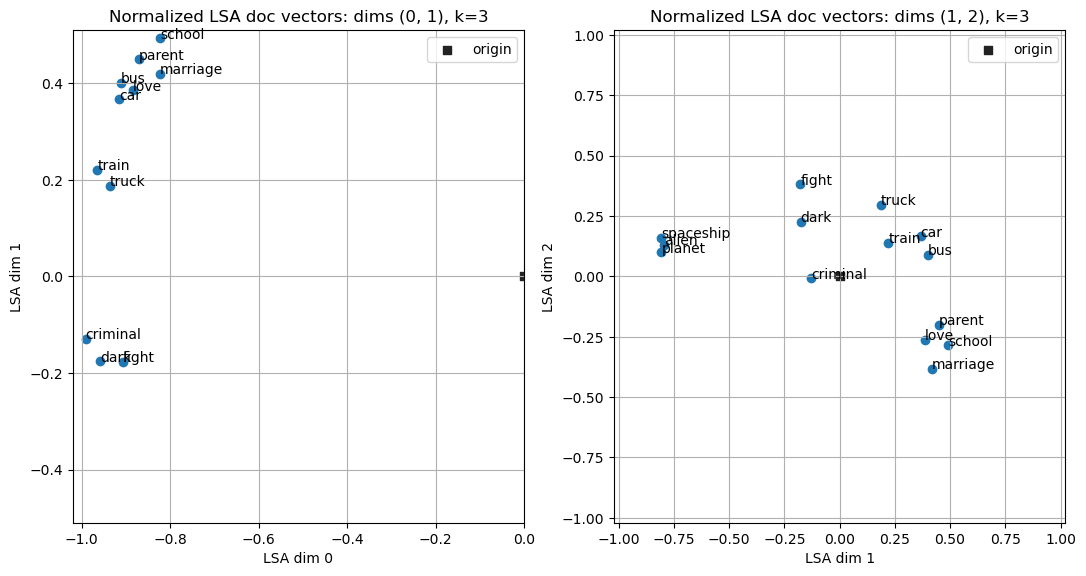

In [28]:
k=3

w, h, dpi = 640*2, 640, 100
fig, axs = plt.subplots(ncols=2, figsize=(w/dpi, h/dpi), dpi=dpi)

plot_words(u, s, labels=vocabulary, ax=axs[0], subset=words_subset, k=k, dimensions=(0,1))
plot_words(u, s, labels=vocabulary, ax=axs[1], subset=words_subset, k=k, dimensions=(1,2))
axs[0].set_xlim(-1.02,0)
axs[0].set_ylim(-0.51,0.51)

axs[1].set_xlim(-1.02,1.02)
axs[1].set_ylim(-1.02,1.02)

plt.show()

### Analyze genres

First, let's see which genres are present.

In [96]:
genres = df['genres'].explode().unique()

genres_frequency = {}
for genre in genres:
    key = 'unknown' if pd.isna(genre) else genre
    genres_frequency[key] = list(df['genres'].explode()).count(genre)

genres_frequency = dict(sorted(genres_frequency.items(), key=lambda item: item[1], reverse=True))

#print the 20 most frequent genres
most_frequent_genres_d = {k: v for i, (k, v) in enumerate(genres_frequency.items()) if i<20}
most_frequent_genres = list(most_frequent_genres_d.keys())

most_frequent_genres_d

{'fiction': 4747,
 'speculative fiction': 4314,
 'unknown': 3718,
 'science fiction': 2870,
 'novel': 2463,
 'fantasy': 2413,
 "children's literature": 2122,
 'mystery': 1396,
 'young adult literature': 825,
 'suspense': 765,
 'crime fiction': 753,
 'historical novel': 654,
 'thriller': 568,
 'horror': 511,
 'romance novel': 435,
 'historical fiction': 388,
 'detective fiction': 341,
 'adventure novel': 330,
 'non-fiction': 230,
 'alternate history': 226}

Here, two semantically very different genres are shown:
 - science fiction
 - historical novel

along with the 10 most interesting words for each genre.

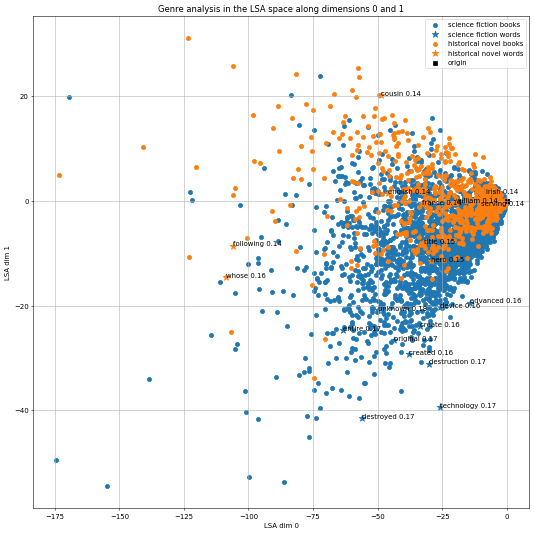

In [319]:
from utils.visualization import plot_genres_analysis
plot_genres_analysis(vt, s, df, genres=["science fiction", "historical novel"], normalize=False, u=u, voc=vocabulary,
                     plot_most_relevant_words=True, n=10)

# Query a document in LSA space

## Curvature of the singular values

Used to find a good value for k. The local minima of the curvature of the singular values is chosen.

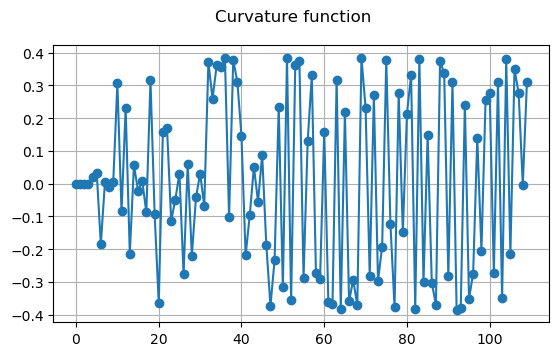

In [298]:
def diff_function(x):
    return x[1:] - x[:-1]

def curvature_function(s):
    s_diff = diff_function(diff_function(s))
    return s_diff/((1+np.square(s_diff))**1.5)

w, h, dpi = 640, 360, 100
fig, ax = plt.subplots(figsize=(w/dpi, h/dpi), dpi=dpi)

ax.plot(curvature_function(s)[:110], 'o-')
ax.grid()
fig.suptitle('Curvature function')

plt.show()

In [225]:
from utils.similarities import compute_cos_similarities

Here, a summary of a science fiction book generated with ChatGPT is used as a query.

The goal is to find the most similar documents to it.

In [365]:
# invented query for a science fiction book, generated with ChatGPT
invented_query = "In the distant future, humanity has unlocked the secrets of time travel, ushering in a new era of exploration and discovery. Dr. Elara Reynolds, a brilliant astrophysicist, stumbles upon an anomaly in the fabric of spacetime - the Chrono Nexus. This enigmatic phenomenon allows for unprecedented access to different points in history, but it comes with a grave warning from an ancient civilization: tampering with time could have catastrophic consequences. Elara, driven by her insatiable curiosity, assembles a team of maverick scientists and historians to explore the depths of the Chrono Nexus. Their journey takes them to pivotal moments in human history, from the construction of the Great Pyramids to the moon landing, and even further back to witness the birth of civilization itself. As they navigate the complexities of time, the team grapples with ethical dilemmas, paradoxes, and the ever-looming threat of altering the course of history irreversibly. Along the way, they encounter shadowy organizations with their own sinister agendas, vying for control over the Chrono Nexus. With the fate of the world hanging in the balance, Elara and her team must race against time to unravel the mysteries of the Chrono Nexus and protect the delicate balance of the space-time continuum. The lines between past, present, and future blur as they confront the ultimate question: Can humanity wield the power of time without succumbing to its consequences? Chrono Nexus is a riveting tale of scientific discovery, moral quandaries, and the enduring spirit of human exploration set against the backdrop of a future where time itself is both a tool and a formidable adversary."

# Build the terms-docs vector representing the query text
terms_docs_vect_query = np.zeros(shape=(len(vocabulary), ))

for word in apply_preprocessing(invented_query):
    if word in voc:
        terms_docs_vect_query[token2id[word]] += 1

terms_docs_vect_query
tf_idf_query = np.log(terms_docs_vect_query+1)*np.log(np.array([document_frequency[token] for token in vocabulary]))

Compute cosine similarity in LSA space with all the documents

In [310]:
def compute_most_similar_docs_lsa(k):
    s_k = s[:k]
    u_k = u[:,:k]
    vt_k = vt[:k,:]

    query_lsa = 1/s_k * np.matmul(u_k.T, tf_idf_query)
    docs_lsa = s_k[:,np.newaxis]*vt_k

    similarities = compute_cos_similarities(query_lsa, docs_lsa)

    return np.argsort(similarities)[::-1], np.sort(similarities)[::-1]


def print_most_similar(k, n=5):
    doc_ranks, similarities = compute_most_similar_docs_lsa(k)
    print(f'k={k}')
    df_display = df.loc[doc_ranks[:n]][['title', 'author', 'genres', 'summary']]
    df_display['similarity'] = similarities[:n]
    display(df_display)

### Analysis

Small k

In [311]:
print_most_similar(3)

k=3


,title,author,genres,summary,similarity
15621,Duties Beyond Borders,NaN,NaN,===The Use of Forc he Promotion of Human Righ...,0.991649
5655,Adiamante,"L. E. Modesitt, Jr.","[science fiction, speculative fiction]",After gaining amazing power over genetics and...,0.988507
13777,Dragon's Honor,NaN,NaN,Captain Picard and the crew of the USS Enterp...,0.986155
5663,The Devil Goblins from Neptune,Keith Topping,"[science fiction, speculative fiction]",The Brigadier is pursued across the world fro...,0.982438
12101,The Creator,Clifford D. Simak,[science fiction],The novelette suggests that our universe was ...,0.982368


Around k=13

In [315]:
print_most_similar(12)
print_most_similar(13)
print_most_similar(14)

k=12


,title,author,genres,summary,similarity
6555,So Vile a Sin,Kate Orman,[speculative fiction],The Doctor returns to the thirtieth century; ...,0.866889
601,The Genesis Quest,NaN,[science fiction],The Genesis Quest gets around the problems in...,0.819434
11405,The Farther Shore,Christie Golden,[science fiction],There is a Borg conspiracy going on on the Ea...,0.810062
7529,Genus Homo,P. Schuyler Miller,"[science fiction, speculative fiction]","A bus is trapped in the cave-in of a tunnel, ...",0.799143
15682,Abduction,Robin Cook,"[thriller, science fiction, novel, speculative...",A team of researchers in a remote region of t...,0.788830


k=13


,title,author,genres,summary,similarity
6555,So Vile a Sin,Kate Orman,[speculative fiction],The Doctor returns to the thirtieth century; ...,0.891380
6395,Tomb of Valdemar,Simon Messingham,"[science fiction, speculative fiction]",The Doctor's quest to fix the Key of Time is ...,0.827651
15682,Abduction,Robin Cook,"[thriller, science fiction, novel, speculative...",A team of researchers in a remote region of t...,0.821321
4869,Only Human,Gareth Roberts,[science fiction],The presence of a Neanderthal on present-day ...,0.812505
8632,The Art of Destruction,Stephen Cole,"[science fiction, speculative fiction]","The TARDIS arrives in 22nd century Africa, wh...",0.798345


k=14


,title,author,genres,summary,similarity
6555,So Vile a Sin,Kate Orman,[speculative fiction],The Doctor returns to the thirtieth century; ...,0.897801
15682,Abduction,Robin Cook,"[thriller, science fiction, novel, speculative...",A team of researchers in a remote region of t...,0.829588
601,The Genesis Quest,NaN,[science fiction],The Genesis Quest gets around the problems in...,0.814182
8632,The Art of Destruction,Stephen Cole,"[science fiction, speculative fiction]","The TARDIS arrives in 22nd century Africa, wh...",0.787520
6395,Tomb of Valdemar,Simon Messingham,"[science fiction, speculative fiction]",The Doctor's quest to fix the Key of Time is ...,0.783637


Around k=20

In [316]:
print_most_similar(19)
print_most_similar(20)
print_most_similar(21)

k=19


,title,author,genres,summary,similarity
6395,Tomb of Valdemar,Simon Messingham,"[science fiction, speculative fiction]",The Doctor's quest to fix the Key of Time is ...,0.858971
6555,So Vile a Sin,Kate Orman,[speculative fiction],The Doctor returns to the thirtieth century; ...,0.855952
7657,The Sea Devil's Eye,Mel Odom,"[speculative fiction, fantasy]",Iakhovas has caused more destruction than any...,0.848718
9439,Goat Song,Frank Yerby,NaN,"Ariston, a Spartiate, is the hero cursed and ...",0.846715
9487,The Time Trap,Edgar Pierre Jacobs,NaN,When Mortimer discovers a time machine built ...,0.838268


k=20


,title,author,genres,summary,similarity
6555,So Vile a Sin,Kate Orman,[speculative fiction],The Doctor returns to the thirtieth century; ...,0.853771
6395,Tomb of Valdemar,Simon Messingham,"[science fiction, speculative fiction]",The Doctor's quest to fix the Key of Time is ...,0.848666
7657,The Sea Devil's Eye,Mel Odom,"[speculative fiction, fantasy]",Iakhovas has caused more destruction than any...,0.841704
9439,Goat Song,Frank Yerby,NaN,"Ariston, a Spartiate, is the hero cursed and ...",0.836984
9487,The Time Trap,Edgar Pierre Jacobs,NaN,When Mortimer discovers a time machine built ...,0.835804


k=21


,title,author,genres,summary,similarity
6395,Tomb of Valdemar,Simon Messingham,"[science fiction, speculative fiction]",The Doctor's quest to fix the Key of Time is ...,0.850655
7657,The Sea Devil's Eye,Mel Odom,"[speculative fiction, fantasy]",Iakhovas has caused more destruction than any...,0.843185
9439,Goat Song,Frank Yerby,NaN,"Ariston, a Spartiate, is the hero cursed and ...",0.839337
6555,So Vile a Sin,Kate Orman,[speculative fiction],The Doctor returns to the thirtieth century; ...,0.837418
9487,The Time Trap,Edgar Pierre Jacobs,NaN,When Mortimer discovers a time machine built ...,0.825952


Around k=101

In [317]:
print_most_similar(100)
print_most_similar(101)
print_most_similar(102)

k=100


,title,author,genres,summary,similarity
6395,Tomb of Valdemar,Simon Messingham,"[science fiction, speculative fiction]",The Doctor's quest to fix the Key of Time is ...,0.594064
601,The Genesis Quest,NaN,[science fiction],The Genesis Quest gets around the problems in...,0.591875
680,Warring States,Mags L Halliday,"[science fiction, speculative fiction]",Cousin Octavia of Faction Paradox has come to...,0.587870
6555,So Vile a Sin,Kate Orman,[speculative fiction],The Doctor returns to the thirtieth century; ...,0.562079
9439,Goat Song,Frank Yerby,NaN,"Ariston, a Spartiate, is the hero cursed and ...",0.534162


k=101


,title,author,genres,summary,similarity
6395,Tomb of Valdemar,Simon Messingham,"[science fiction, speculative fiction]",The Doctor's quest to fix the Key of Time is ...,0.593201
680,Warring States,Mags L Halliday,"[science fiction, speculative fiction]",Cousin Octavia of Faction Paradox has come to...,0.586751
601,The Genesis Quest,NaN,[science fiction],The Genesis Quest gets around the problems in...,0.583523
6555,So Vile a Sin,Kate Orman,[speculative fiction],The Doctor returns to the thirtieth century; ...,0.567829
9439,Goat Song,Frank Yerby,NaN,"Ariston, a Spartiate, is the hero cursed and ...",0.534648


k=102


,title,author,genres,summary,similarity
6395,Tomb of Valdemar,Simon Messingham,"[science fiction, speculative fiction]",The Doctor's quest to fix the Key of Time is ...,0.594074
680,Warring States,Mags L Halliday,"[science fiction, speculative fiction]",Cousin Octavia of Faction Paradox has come to...,0.588325
601,The Genesis Quest,NaN,[science fiction],The Genesis Quest gets around the problems in...,0.583384
6555,So Vile a Sin,Kate Orman,[speculative fiction],The Doctor returns to the thirtieth century; ...,0.565745
9439,Goat Song,Frank Yerby,NaN,"Ariston, a Spartiate, is the hero cursed and ...",0.539479
